# Emissions Model Training with K-Means Clustering

This file contains the model training for K-Means clustering aiming to group boroughs into clusters based on pollution caused by different types of vehicles.


#### Objective:
The objective is to train a K-Means clustering model that categorizes boroughs into clusters based on their overall emissions profile.

#### Input:
The input data consists of the following features:

| Name                   | Description                                 | Column Name           | Data Type |
|------------------------|---------------------------------------------|-----------------------|-----------|
| Borough Name           | Exact borough name                          | BoroughName_ExactCut  | Object    |
| Pollutant              | Amount of pollution caused by vehicles      | Pollutant             | Float64   |
| Petrol Car             | Amount of pollution caused by petrol cars   | PetrolCar             | Float64   |
| Diesel Car             | Amount of pollution caused by diesel cars   | DieselCar             | Float64   |
| Petrol LGV             | Amount of pollution caused by petrol LGVs   | PetrolLgv             | Float64   |
| Diesel LGV             | Amount of pollution caused by diesel LGVs   | DieselLgv             | Float64   |
| Electric Car           | Amount of pollution caused by electric cars | ElectricCar           | Float64   |
| Electric LGV           | Amount of pollution caused by electric LGVs | ElectricLgv           | Float64   |

#### Output:
The trained K-Means clustering model groups boroughs into clusters based on their overall emissions profile.


### Imports

In [5]:
import pandas as pd

### Reading the Dataset

In [6]:
pd.read_csv('./data/emissions_clean_train.csv')

,BoroughName_ExactCut,Length (m),Pollutant,PetrolCar,DieselCar,PetrolLgv,DieselLgv,ElectricCar,ElectricLgv
0,Sutton,45.107010,PM25_Exhaust,0.000009,0.000066,3.799868e-08,0.000028,0.000000e+00,0.000000e+00
1,Bromley,62.022810,PM25_Tyre,0.001003,0.000595,2.588475e-06,0.000130,5.319796e-07,7.445220e-08
2,Croydon,111.885582,PM25_Brake,0.001932,0.001146,1.002070e-05,0.000503,1.024189e-06,2.882250e-07
3,Hounslow,9.980484,PM10_Tyre,0.000205,0.000122,1.206538e-06,0.000061,1.089011e-07,3.470361e-08
4,Bromley,97.352526,PM10_Exhaust,0.000193,0.001376,7.926688e-07,0.000576,0.000000e+00,0.000000e+00
...,...,...,...,...,...,...,...,...,...
292971,Barnet,98.491668,CO2,20.303021,11.169755,8.849195e-02,3.985283,0.000000e+00,0.000000e+00
292972,Bromley,24.505723,PM10_Exhaust,0.000124,0.000899,5.166168e-07,0.000383,0.000000e+00,0.000000e+00
292973,Brent,8.602341,PM10_Brake,0.000298,0.000177,1.220624e-06,0.000061,1.579268e-07,3.510876e-08
292974,Hillingdon,118.818462,PM25_Brake,0.005057,0.003001,1.903584e-05,0.000956,2.681507e-06,5.475271e-07


In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [8]:
d1 = pd.read_csv('./data/emissions_clean_train.csv')
d1.head(10)

,BoroughName_ExactCut,Length (m),Pollutant,PetrolCar,DieselCar,PetrolLgv,DieselLgv,ElectricCar,ElectricLgv
0,Sutton,45.107010,PM25_Exhaust,0.000009,0.000066,3.799868e-08,0.000028,0.000000e+00,0.000000e+00
1,Bromley,62.022810,PM25_Tyre,0.001003,0.000595,2.588475e-06,0.000130,5.319796e-07,7.445220e-08
2,Croydon,111.885582,PM25_Brake,0.001932,0.001146,1.002070e-05,0.000503,1.024189e-06,2.882250e-07
3,Hounslow,9.980484,PM10_Tyre,0.000205,0.000122,1.206538e-06,0.000061,1.089011e-07,3.470361e-08
4,Bromley,97.352526,PM10_Exhaust,0.000193,0.001376,7.926688e-07,0.000576,0.000000e+00,0.000000e+00
5,City of Westminster,78.746433,PM25_Tyre,0.000831,0.000493,7.819163e-06,0.000393,4.407879e-07,2.249023e-07
6,City of Westminster,56.058738,PM10_Brake,0.002279,0.001352,1.208650e-05,0.000607,1.208498e-06,3.476435e-07
7,Bromley,317.198424,PM10_Tyre,0.001780,0.001056,9.669837e-06,0.000486,9.435891e-07,2.781332e-07
8,Richmond,29.019248,PM10_Brake,0.002191,0.001300,1.184255e-05,0.000595,1.161811e-06,3.406267e-07
9,Hillingdon,12.991396,PM10_Brake,0.000079,0.000047,4.305998e-07,0.000022,4.211042e-08,1.238533e-08


In [9]:
d1.shape

(292976, 9)

In [11]:
d1.columns

Index(['BoroughName_ExactCut', 'Length (m)', 'Pollutant', 'PetrolCar',
       'DieselCar', 'PetrolLgv', 'DieselLgv', 'ElectricCar', 'ElectricLgv'],
      dtype='object')

In [12]:
d1.describe()

,Length (m),PetrolCar,DieselCar,PetrolLgv,DieselLgv,ElectricCar,ElectricLgv
count,292976.000000,2.929760e+05,2.929760e+05,2.929760e+05,2.929760e+05,2.929760e+05,2.929760e+05
mean,64.709192,1.722828e+00,9.261293e-01,7.898672e-03,3.590049e-01,4.013537e-07,1.175537e-07
std,82.335105,1.041743e+01,5.526875e+00,4.726665e-02,2.143656e+00,1.345926e-06,3.994530e-07
min,0.000046,6.132771e-12,3.638901e-12,3.951580e-14,2.346097e-12,0.000000e+00,0.000000e+00
25%,13.325453,6.069628e-05,8.387451e-05,2.874930e-07,3.791325e-05,0.000000e+00,0.000000e+00
50%,40.315343,3.647204e-04,4.436093e-04,1.889703e-06,2.024828e-04,1.365041e-08,3.336524e-09
75%,83.005493,2.507702e-03,2.467542e-03,1.498358e-05,1.113029e-03,2.648649e-07,7.579654e-08
max,1275.112939,7.952527e+02,3.935547e+02,3.978381e+00,1.773783e+02,8.859117e-05,2.592419e-05


In [13]:
d1.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 292976 entries, 0 to 292975
Data columns (total 9 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   BoroughName_ExactCut  292976 non-null  object 
 1   Length (m)            292976 non-null  float64
 2   Pollutant             292976 non-null  object 
 3   PetrolCar             292976 non-null  float64
 4   DieselCar             292976 non-null  float64
 5   PetrolLgv             292976 non-null  float64
 6   DieselLgv             292976 non-null  float64
 7   ElectricCar           292976 non-null  float64
 8   ElectricLgv           292976 non-null  float64
dtypes: float64(7), object(2)
memory usage: 20.1+ MB


array([[<Axes: title={'center': 'Length (m)'}>,
        <Axes: title={'center': 'PetrolCar'}>,
        <Axes: title={'center': 'DieselCar'}>],
       [<Axes: title={'center': 'PetrolLgv'}>,
        <Axes: title={'center': 'DieselLgv'}>,
        <Axes: title={'center': 'ElectricCar'}>],
       [<Axes: title={'center': 'ElectricLgv'}>, <Axes: >, <Axes: >]],
      dtype=object)

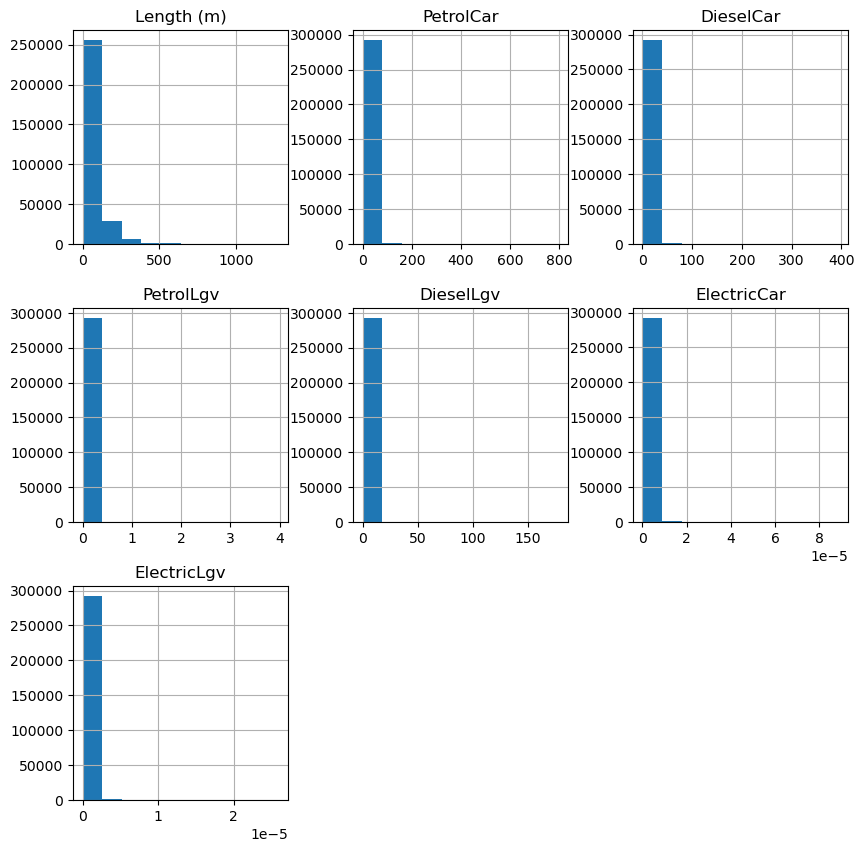

In [14]:
d1.hist(figsize=(10,10))

In [15]:
d1.isnull().sum()

BoroughName_ExactCut    0
Length (m)              0
Pollutant               0
PetrolCar               0
DieselCar               0
PetrolLgv               0
DieselLgv               0
ElectricCar             0
ElectricLgv             0
dtype: int64

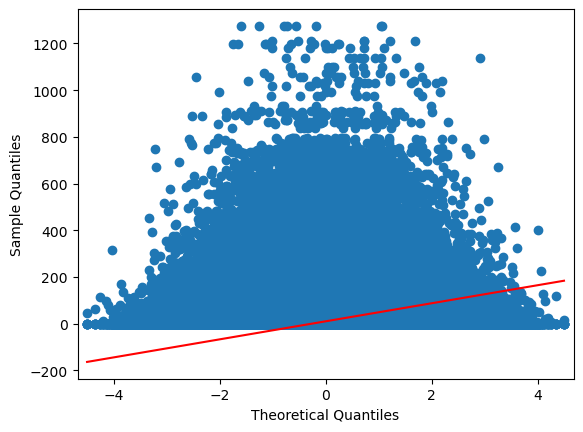

In [16]:
from statsmodels.graphics.gofplots import qqplot

qqplot(d1[['Length (m)','PetrolCar','DieselCar','PetrolLgv','DieselLgv','ElectricCar','ElectricLgv']],line='s')
plt.show()

In [17]:
from scipy.stats import skew

print(skew(d1[['Length (m)','PetrolCar','DieselCar','PetrolLgv','DieselLgv','ElectricCar','ElectricLgv']]))

[ 3.81931738 15.94509899 14.62396407 16.61223825 16.43024294 11.21417674
 11.38478847]


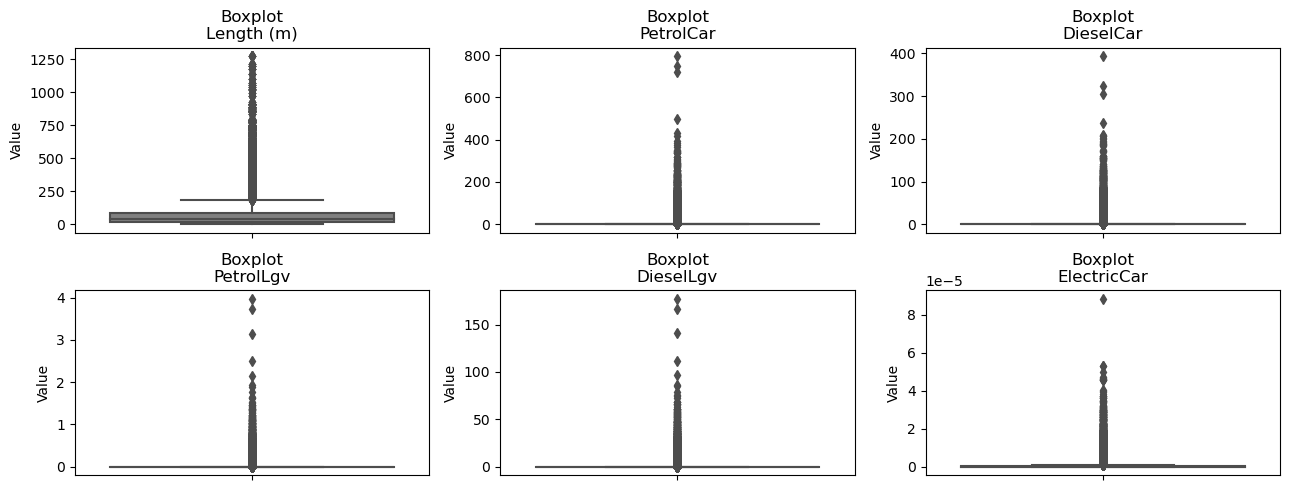

In [18]:
plt.figure(figsize=(13,5))

for feat, grd in zip(d1[['Length (m)','PetrolCar','DieselCar','PetrolLgv','DieselLgv','ElectricCar','ElectricLgv']], range(231,237)):
    plt.subplot(grd)
    sns.boxplot(y=d1[feat], color='grey')
    plt.ylabel('Value')
    plt.title('Boxplot\n%s'%feat)
plt.tight_layout()

In [19]:
y1 = d1['BoroughName_ExactCut']
X1 = d1[['Length (m)','PetrolCar','DieselCar','PetrolLgv','DieselLgv','ElectricCar','ElectricLgv']]

(292976, 7)


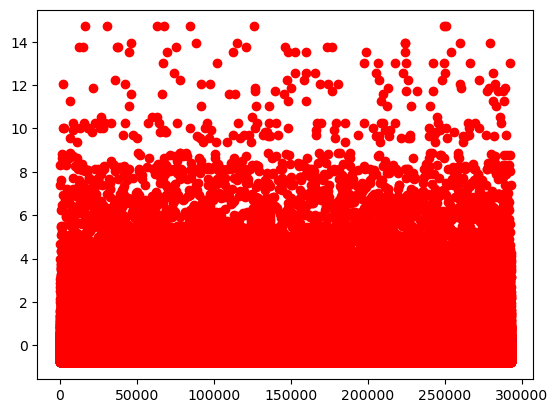

In [20]:
# Scaling Data using Min-Max Scaler

from sklearn.preprocessing import MinMaxScaler
mms = MinMaxScaler()
X_norm_1 = mms.fit_transform(X1)

# Scaling Data using Standard Scaler

from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scaler.fit(X1)
X_std_1 = scaler.transform(X1)


# Comparing Scaled Data

xx = np.arange(len(X_std_1))
yy1 = X_norm_1[:,0]
yy2 = X_std_1[:,0]
plt.scatter(xx,yy1,color='b')
plt.scatter(xx,yy2,color='r')

print(X_std_1.shape)

In [21]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca_1 = pca.fit_transform(X_norm_1)

In [22]:
from sklearn.cluster import KMeans

model1 = KMeans(random_state=21,n_clusters=3)
model1.fit(X_pca_1)

C:\Users\amondal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


KMeans(n_clusters=3, random_state=21)

In [23]:
model1.labels_

array([1, 1, 0, ..., 1, 0, 1])

In [24]:
k1=model1.cluster_centers_
k1

array([[ 5.90748912e-02,  4.80614007e-04],
       [-2.62877813e-02, -1.01750193e-04],
       [ 2.82013826e-01, -1.04894968e-03]])

In [25]:
s = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters = i, init = 'k-means++', random_state = 42)
    kmeans.fit(X_pca_1)
    s.append(kmeans.inertia_)

C:\Users\amondal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\amondal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\amondal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
C:\Users\amondal\anaconda3\Lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the 

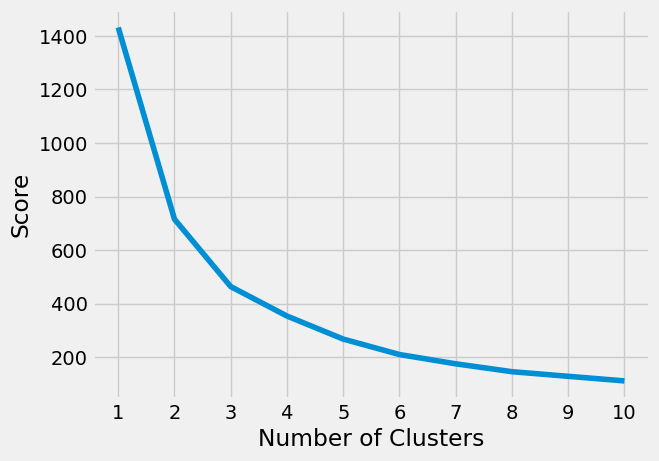

In [26]:
plt.style.use("fivethirtyeight")
plt.plot(range(1, 11), s)
plt.xticks(range(1, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Score")
plt.show()

In [27]:
pip install kneed

  Obtaining dependency information for kneed from https://files.pythonhosted.org/packages/9a/1b/7e726d8616e813007874468c61790099ba21493e0ea07561b7d9fc53151c/kneed-0.8.5-py3-none-any.whl.metadata
Note: you may need to restart the kernel to use updated packages.


In [28]:
from kneed import KneeLocator
kl = KneeLocator(range(1,11),s,curve="convex",direction="decreasing")
kl.elbow

3